# Quora question pairs: training

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Initialize global variables

In [2]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1

## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [4]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [5]:
Q1 = Sequential()
Q1.add(Embedding(nb_words + 1, EMBEDDING_DIM, weights=[word_embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
Q1.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q1.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM, )))
Q2 = Sequential()
Q2.add(Embedding(nb_words + 1, EMBEDDING_DIM, weights=[word_embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
Q2.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q2.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM, )))
model = Sequential()
model.add(Merge([Q1, Q2], mode='concat'))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())
model.add(Dense(EMBEDDING_DIM*2, activation='relu', W_regularizer=l2(4e-6)))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())
model.add(Dense(EMBEDDING_DIM*2, activation='relu', W_regularizer=l2(4e-6)))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())
model.add(Dense(EMBEDDING_DIM*2, activation='relu', W_regularizer=l2(4e-6)))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model, checkpointing weights with best validation accuracy

In [6]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    nb_epoch=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-01-31 16:56:24.595839
Train on 327523 samples, validate on 36392 samples
Epoch 1/25
154s - loss: 0.5411 - acc: 0.7312 - val_loss: 0.4953 - val_acc: 0.7588
Epoch 2/25
144s - loss: 0.4980 - acc: 0.7622 - val_loss: 0.4775 - val_acc: 0.7774
Epoch 3/25
151s - loss: 0.4802 - acc: 0.7755 - val_loss: 0.4655 - val_acc: 0.7860
Epoch 4/25
145s - loss: 0.4674 - acc: 0.7845 - val_loss: 0.4557 - val_acc: 0.7941
Epoch 5/25
148s - loss: 0.4582 - acc: 0.7904 - val_loss: 0.4528 - val_acc: 0.7947
Epoch 6/25
164s - loss: 0.4494 - acc: 0.7968 - val_loss: 0.4488 - val_acc: 0.7963
Epoch 7/25
157s - loss: 0.4435 - acc: 0.8014 - val_loss: 0.4416 - val_acc: 0.8019
Epoch 8/25
144s - loss: 0.4386 - acc: 0.8045 - val_loss: 0.4387 - val_acc: 0.8053
Epoch 9/25
149s - loss: 0.4327 - acc: 0.8089 - val_loss: 0.4433 - val_acc: 0.8000
Epoch 10/25
143s - loss: 0.4286 - acc: 0.8109 - val_loss: 0.4334 - val_acc: 0.8064
Epoch 11/25
143s - loss: 0.4242 - acc: 0.8145 - val_loss: 0.4305 - val_acc: 0.81

## Plot training and validation accuracy

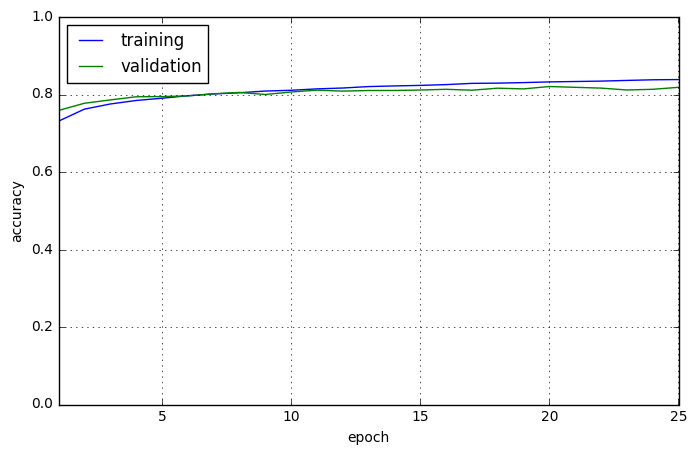

In [10]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

In [8]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 20 = 0.8206


## Evaluate the model with best validation accuracy on the test partition

In [9]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test)
print('Test loss = {0:.4f}, test accuracy = {1:.4f}'.format(loss, accuracy))

40416/40436 [============================>.] - ETA: 0s